### https://medium.com/@ianvonseggern/note-recognition-in-python-c2020d0dae24

In [20]:
import matplotlib.pyplot as plt
from pydub import AudioSegment
import numpy as np
import librosa

In [21]:
input_cleaned_filename = "mp3_input/bass_NGHYB_clean_20_seconds.mp3"

song = AudioSegment.from_file(input_cleaned_filename)
x, sr = librosa.load(input_cleaned_filename)

# Size of segments to break song into for volume calculations
SEGMENT_MS = 50
# dBFS is decibels relative to the maximum possible loudness
volume = [segment.dBFS for segment in song[::SEGMENT_MS]]

In [29]:
volume = volume[:150]

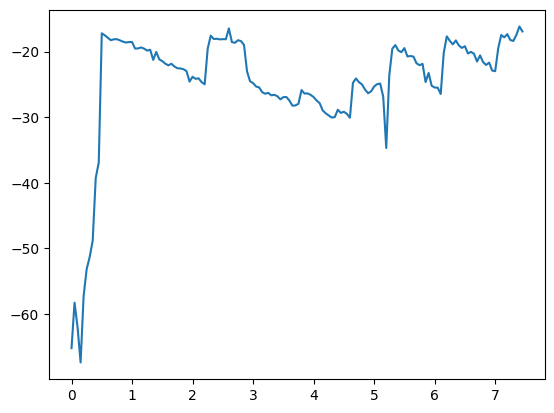

In [30]:
x_axis = np.arange(len(volume)) * (SEGMENT_MS / 1000)
plt.plot(x_axis, volume)
plt.show()

In [34]:
strums = [0.491, 1.404, 2.282, 2.620, 2.876, 3.799, 4.618, 4.888, 5.275, 6.184, 7.084, 7.426, 7.715]
strums_light = [2.0165, 3.511, 4.420, 5.896, 6.767]

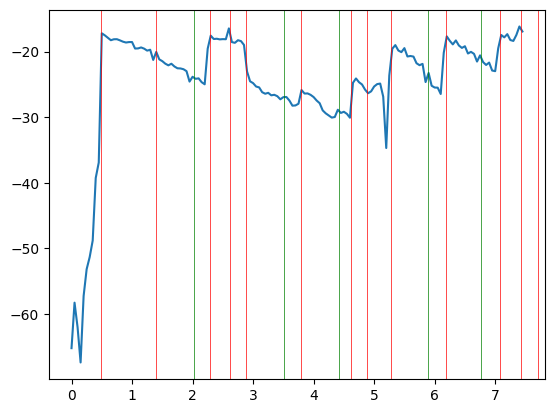

In [35]:
x_axis = np.arange(len(volume)) * (SEGMENT_MS / 1000)
plt.plot(x_axis, volume)

for s in strums:
    plt.axvline(x=s, color='r', linewidth=0.5, linestyle="-")
for s in strums_light:
    plt.axvline(x=s, color='g', linewidth=0.5, linestyle="-")

plt.show()

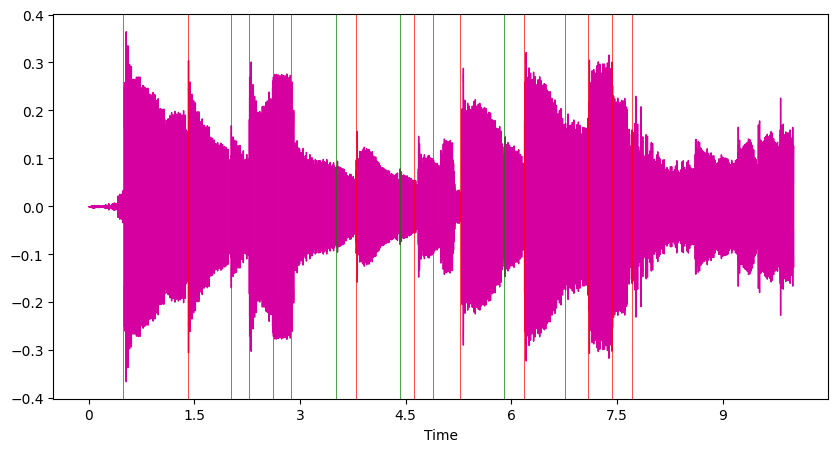

In [36]:
seconds_start = 0
seconds_end = 10
x_custom_time = x[seconds_start * sr :seconds_end*sr]

figure, axis = plt.subplots(1, figsize=(10, 5)) 

librosa.display.waveshow(x_custom_time, sr=sr, color = "#d600a1") 

for s in strums:
    plt.axvline(x=s, color='r', linewidth=0.5, linestyle="-")
for s in strums_light:
    plt.axvline(x=s, color='g', linewidth=0.5, linestyle="-")

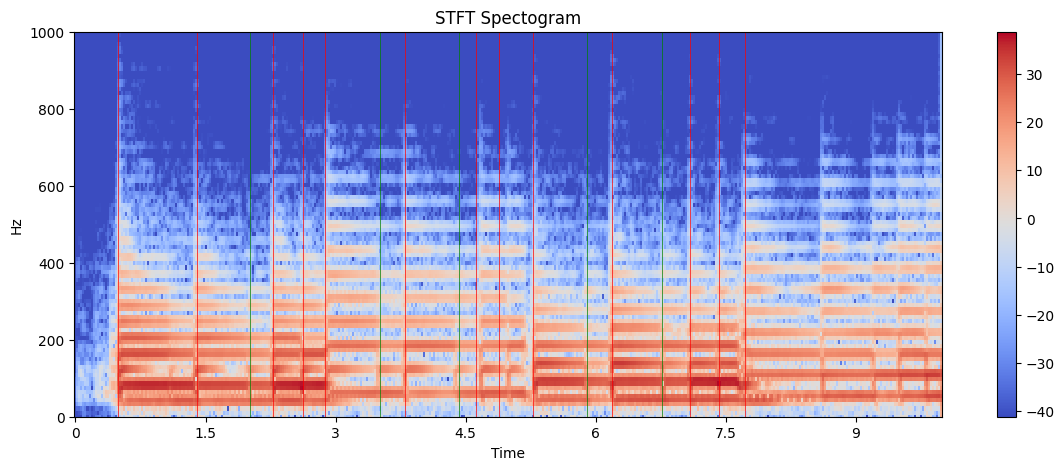

In [37]:
# x , sr = librosa.load(audio_path, sr = 22050) #loading the 11th file just for trial
X = librosa.stft(x_custom_time)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0, 1000)
plt.title('STFT Spectogram')
plt.colorbar()

for s in strums:
    plt.axvline(x=s, color='r', linewidth=0.5, linestyle="-")
for s in strums_light:
    plt.axvline(x=s, color='g', linewidth=0.5, linestyle="-")

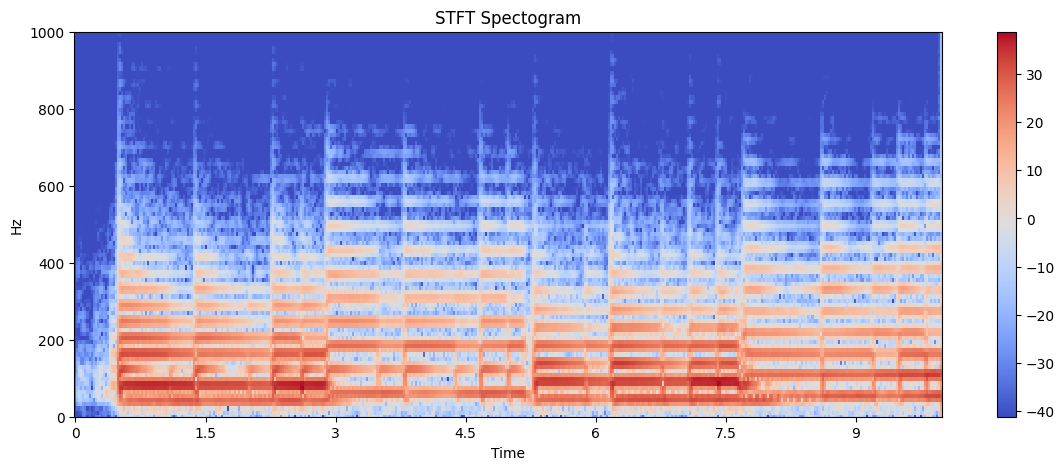

In [26]:
# x , sr = librosa.load(audio_path, sr = 22050) #loading the 11th file just for trial
X = librosa.stft(x_custom_time)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0, 1000)
plt.title('STFT Spectogram')
plt.colorbar()

In [45]:
import numpy as np
import librosa
import librosa.display
from scipy.signal import find_peaks, medfilt
from scipy.ndimage import gaussian_filter1d
# optional:
from sklearn.cluster import KMeans

# --- params (tune these) ---
audio_path = input_cleaned_filename
sr = 22050                # feparam['fs'] — sampling rate to load/resample to
n_fft = 2048              # window length in samples (could use feparam['wl'])
hop_length = 512
low_hz, high_hz = 40, 200 # bass band — tune as needed
analysis_duration = 7.7   # seconds: only analyze first 7.7s

# --- load (mono) ---
y, sr = librosa.load(audio_path, sr=sr, mono=True, duration=analysis_duration)

# --- STFT magnitude or power spectrogram ---
S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))**2  # power spectrogram
freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

# --- select bass band rows and sum to get band energy time series ---
band_mask = (freqs >= low_hz) & (freqs <= high_hz)
if not band_mask.any():
    raise RuntimeError("No frequency bins in chosen band — adjust n_fft or band limits.")
band_energy = S[band_mask].sum(axis=0)   # shape: (n_frames,)

# --- optional: convert to dB and normalize (helps peak picking) ---
band_db = librosa.power_to_db(band_energy, ref=np.max)
band_db = (band_db - band_db.mean()) / (band_db.std() + 1e-8)

# --- smoothing to reduce noise (choose method and kernel size) ---
smoothed = gaussian_filter1d(band_db, sigma=1.5)
# or: smoothed = medfilt(band_db, kernel_size=7)

# --- peak picking in the time-series ---
# tweak height and prominence to control sensitivity
peaks, props = find_peaks(smoothed, height=0, prominence=0.3, distance=int(0.05 * sr / hop_length))


In [44]:
peak_heights = props["peak_heights"]

# --- frame -> time conversion ---
peak_times = librosa.frames_to_time(peaks, sr=sr, hop_length=hop_length)

# --- classify strong vs weak ---
# Option A: percentile threshold (simple)
threshold = np.percentile(peak_heights, 70)   # top 30% = strong
strong_idx = peak_heights >= threshold
weak_idx = peak_heights < threshold
strong_times = peak_times[strong_idx]
weak_times = peak_times[weak_idx]

# Option B: automatic 2-cluster split (KMeans) — robust to different dynamics
# heights_reshaped = peak_heights.reshape(-1,1)
# kmeans = KMeans(n_clusters=2, random_state=0).fit(heights_reshaped)
# labels = kmeans.labels_
# choose cluster with larger mean label -> strong
# strong_cluster = np.argmax([peak_heights[labels==c].mean() for c in [0,1]])
# strong_times = peak_times[labels==strong_cluster]
# weak_times = peak_times[labels!=strong_cluster]

# --- results ---
print("Detected peaks (all):", len(peak_times))
print("Strong:", len(strong_times), "times ->", np.round(strong_times, 3))
print("Weak:",   len(weak_times),   "times ->", np.round(weak_times, 3))


Detected peaks (all): 6
Strong: 2 times -> [2.624 7.43 ]
Weak: 4 times -> [0.789 4.737 5.387 6.269]


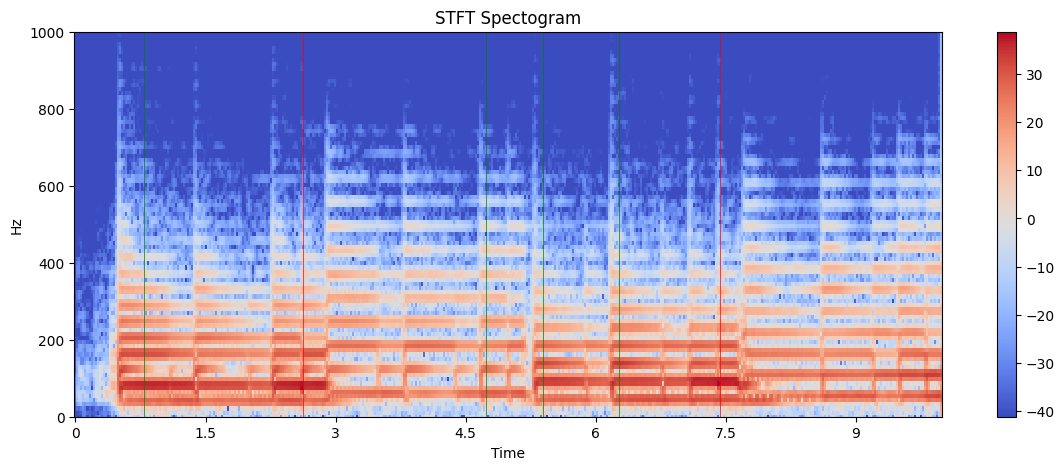

In [48]:
# x , sr = librosa.load(audio_path, sr = 22050) #loading the 11th file just for trial
X = librosa.stft(x_custom_time)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0, 1000)
plt.title('STFT Spectogram')
plt.colorbar()

for s in strong_times:
    plt.axvline(x=s, color='r', linewidth=0.5, linestyle="-")
for s in weak_times:
    plt.axvline(x=s, color='g', linewidth=0.5, linestyle="-")

### Peak Finding 2d Array  
https://stackoverflow.com/questions/75490868/how-to-get-mel-spectagram-peaks-array-in-python

In [ ]:
import librosa
import numpy as np
import scipy.ndimage

def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None, seconds_end = 10):
    seconds_start = 0
    
    x, Fs = librosa.load(fn_wav, sr=Fs)

    x = x[seconds_start * sr :seconds_end*sr]

    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hamming')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[0]
    Y = np.abs(X[:bin_max, :frame_max])
    return Y

def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (implementation using image processing)    
    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    result = scipy.ndimage.maximum_filter(Y, size=[2*dist_freq+1, 2*dist_time+1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap

# path = librosa.example('nutcracker')
spec = compute_spectrogram(input_cleaned_filename,Fs = sr)
Cmap = compute_constellation_map(spec, dist_freq=7, dist_time=3)
print(Cmap.shape)

(128, 431)


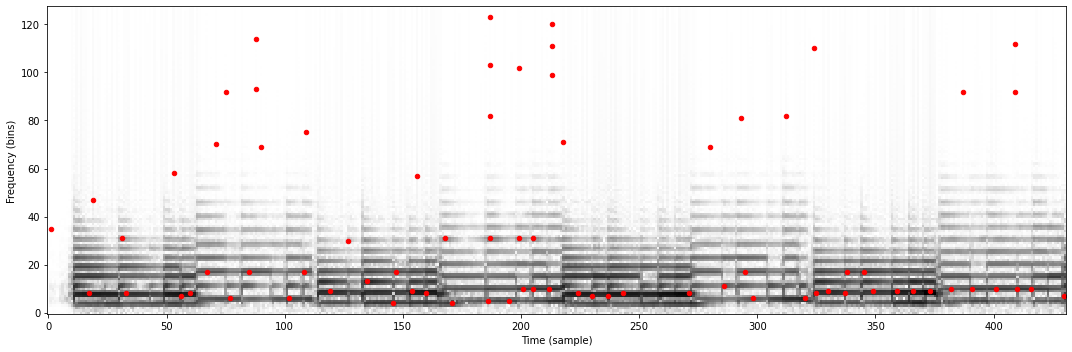

In [61]:
import matplotlib.pyplot as plt

def plot_constellation_map(Cmap, Y=None, xlim=None, ylim=None, title='',
                           xlabel='Time (sample)', ylabel='Frequency (bins)',
                           s=5, color='r', marker='o', figsize=(7, 3), dpi=72):
    if Cmap.ndim > 1:
        (K, N) = Cmap.shape
    else:
        K = Cmap.shape[0]
        N = 1
    if Y is None:
        Y = np.zeros((K, N))
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    im = ax.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    Fs = 1
    if xlim is None:
        xlim = [-0.5/Fs, (N-0.5)/Fs]
    if ylim is None:
        ylim = [-0.5/Fs, (K-0.5)/Fs]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    n, k = np.argwhere(Cmap == 1).T
    ax.scatter(k, n, color=color, s=s, marker=marker)
    plt.tight_layout()
    return fig, ax, im

fig, ax, im = plot_constellation_map(Cmap, np.log(1 + 1 * spec), color='r', s=20, figsize=(15, 5))
fig.savefig('constellation-map.png')